## homework 4 of Classic

## Original Question

The goal of this quantum program is to simulate a quantum random walk on a line topology with 16 nodes.
In a line topology, the nodes are arranged sequentially, and each node is connected to its immediate neighbors. For example, consider a line of 16 nodes numbered from 0 to 15. In this walk, the walker would move from its current node to an adjacent node (either left or right) with equal probability.

Beacuse implementing 16 nodes requires 37 qubits to synthesize, which cannot be done by Classiq's free account, I reduce the problem to 8 nodes.



to prepare the coin operator (or the W operator), we need to define a repeat function which represents the sigma in its formula and inside this repeat, we use a Control Function and also and  within-apply function to form our desired formula of C.

the code has 6 parts that I explain each one of them and their role in here:

1.Prepare Minus State: The prepare_minus function prepares a qubit in the |-⟩ state, which is the state with a phase of 180 degrees.

2.Diffuser Oracle: The diffuzer_oracle function implements the diffuser oracle for Grover's algorithm. This is used in the zero_diffuzer function to perform the zero diffuser operation for the quantum walk.

3.Coin Operation (C-Operator): The C_iteration function defines the coin operation for the quantum walk. The coin operation determines the probability of the walker moving to the left or right node. If the walker is at the first or last node, it can only move to the adjacent node in the allowed direction. Otherwise, the walker has a 50% chance of moving left or right. The C_operator function applies the coin operation to all vertices.

4.Shift Operation (S-Operator): The edge_oracle function checks if two vertices are adjacent. The bitwise_swap function swaps the values of two QArrays bit by bit. The S_operator function applies the shift operator to swap the vertices with their adjacent vertices.

5.Main Function: The main function allocates qubits for the vertices and adjacent vertices, applies the Hadamard transform to initialize the superposition, and then applies the coin and shift operators.

6.Quantum Model and Synthesis: The code creates a quantum model using the create_model function and then synthesizes the quantum program using the synthesize function.

In [17]:
from classiq import *
from classiq.qmod.symbolic import logical_or
from classiq.execution import ExecutionPreferences
size = 3 # Number of qubits to represent the vertices (log2 of 16 nodes)
num_nodes = 2**size # Total number of nodes (16 nodes)

# Function to prepare a qubit in the |-> state
@qfunc
def prepare_minus(x: QBit):
    """
    Prepares a qubit in the |-> state.
    
    Args:
        x (QBit): The qubit to prepare.
    """
    X(x)
    H(x)

@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
    """
    Implements a diffuser oracle for Grover's algorithm.
    
    Args:
        aux (Output[QNum]): Auxiliary qubit.
        x (QNum): QNum representing the node to check.
    """
    aux^=(x!=0)

@qfunc
def zero_diffuzer(x: QNum):
    """
    Implements the zero diffuser for the quantum walk.
    
    Args:
        x (QNum): QNum representing the current node.
    """
    aux = QNum('aux')
    allocate(1,aux)
    within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)

def C_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):
    """
    Defines the coin operation for the quantum walk.
    
    Args:
        i (int): Current node index.
        vertices (QNum): QNum representing the vertices.
        adjacent_vertices (QNum): QNum representing the adjacent vertices.
    """
    prob = [0]*num_nodes  # Initialize probability vector for 8 nodes
    if i == 0:
        prob[i + 1] = 1.0  # If at the first node, move to the right node (node 1)
    elif i == num_nodes - 1:
        prob[i - 1] = 1.0  # If at the last node, move to the left node (node 7)
    else:
        prob[i - 1] = 0.5  # Probability of moving to the left node
        prob[i + 1] = 0.5  # Probability of moving to the right node
    print(f'Node={i}, prob vec ={prob}')
    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))

@qfunc 
def C_operator(vertices:QNum, adjacent_vertices: QNum):
    """
    Applies the coin operator to all vertices.
    
    Args:
        vertices (QNum): QNum representing the vertices.
        adjacent_vertices (QNum): QNum representing the adjacent vertices.
    """
    for i in range(num_nodes):
        C_iteration(i,vertices,adjacent_vertices)

@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
    """
    Oracle that checks if two vertices are adjacent.
    
    Args:
        res (Output[QBit]): Result bit to store the adjacency check.
        vertices (QNum): QNum representing the vertices.
        adjacent_vertices (QNum): QNum representing the adjacent vertices.
    """
    res |= (((vertices - adjacent_vertices) == 1) | ((vertices - adjacent_vertices) == -1))

@qfunc 
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
    """
    Swaps the values of two QArrays bit by bit.
    
    Args:
        x (QArray[QBit]): First QArray of qubits.
        y (QArray[QBit]): Second QArray of qubits.
    """
    repeat(count= x.len,
           iteration= lambda i: SWAP(x[i],y[i])) 

@qfunc 
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    """
    Applies the shift operator to swap vertices with their adjacent vertices.
    
    Args:
        vertices (QNum): QNum representing the vertices.
        adjacent_vertices (QNum): QNum representing the adjacent vertices.
    """
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))
    
@qfunc 
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):
    """
    Main function to perform the quantum random walk.
    
    Args:
        vertices (Output[QNum]): Output QNum to represent vertices.
        adjacent_vertices (Output[QNum]): Output QNum to represent adjacent vertices.
    """
    allocate(size, vertices)  # Allocate qubits for vertices
    hadamard_transform(vertices)  # Apply Hadamard transform to initialize superposition
    allocate(size, adjacent_vertices)  # Allocate qubits for adjacent vertices
    
    C_operator(vertices, adjacent_vertices)  # Apply coin operator
    S_operator(vertices, adjacent_vertices)  # Apply shift operator
    # Create and synthesize the quantum model
quantum_model = create_model(main)
#qprog = synthesize(qmod)
#show(qprog)

Node=0, prob vec =[0, 1.0, 0, 0, 0, 0, 0, 0]
Node=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0]
Node=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0]
Node=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0]
Node=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0]
Node=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0]
Node=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5]
Node=7, prob vec =[0, 0, 0, 0, 0, 0, 1.0, 0]


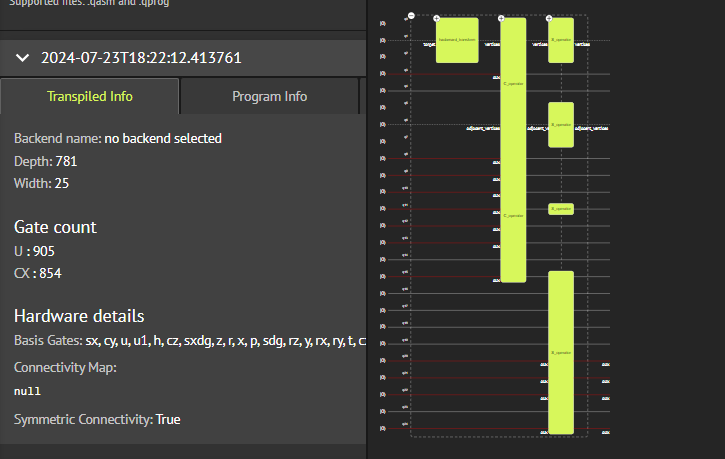

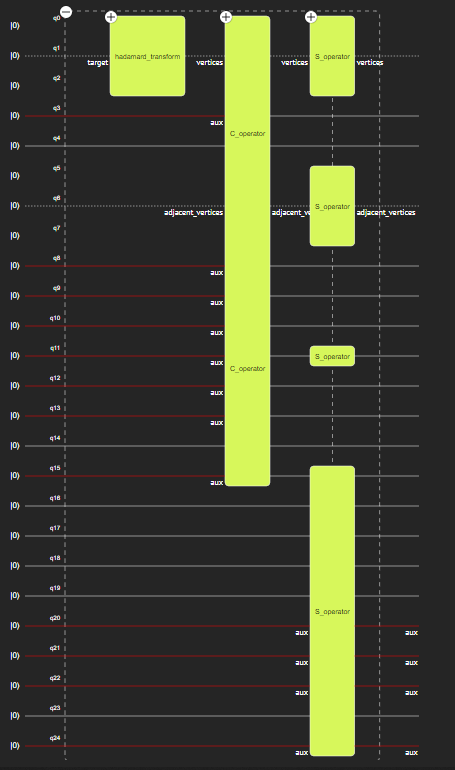

As it can be seen from the circuit information, the circuit depth is 781 and the width is 25. to optimize the depth I wrote an optimization code and defined a constarint on the depth to be the maximum of 776.

In [24]:
quantum_model_with_constraints = set_constraints(
   quantum_model, Constraints(optimization_parameter="depth", max_width=500)
)
quantum_program = synthesize(quantum_model_with_constraints)
circuit_width = QuantumProgram.from_qprog(quantum_program).data.width
circuit_depth = QuantumProgram.from_qprog(quantum_program).transpiled_circuit.depth
print(f"The circuit width is {circuit_width} and the circuit_depth is {circuit_depth}")
show(qprog)

The circuit width is 81 and the circuit_depth is 574
Opening: https://platform.classiq.io/circuit/1345a903-2573-4a8d-89d4-38b6ff890871?version=0.43.3


By optimizing the depth we can reduce the depth from 781 to 574 while the width is 81.
